In [32]:
import csv
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# !wget --no-check-certificate \
#     https://storage.googleapis.com/laurencemoroney-blog.appspot.com/bbc-text.csv \
#     -O /tmp/bbc-text.csv

In [33]:
from urllib.request import urlopen
import codecs
url = 'https://storage.googleapis.com/laurencemoroney-blog.appspot.com/bbc-text.csv'
reader = csv.reader(codecs.iterdecode(urlopen(url), 'utf-8'), delimiter=',')

texts = []
labels = []
stopwords = [ "a", "about", "above", "after", "again", "against", "all", 'also' "am", "an", "and", "any", "are",\
             "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", \
             "by", 'can', "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", \
             "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", \
             "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", \
             "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", \
             "most", "my", "myself", 'no', 'not', "nor", "of", "on", "once", "only", "or", "other", "ought", "our", \
             "ours", "ourselves", "out", "over", "own", 's', "same", "she", "she'd", "she'll", "she's", "should",\
             "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", \
             "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", \
             "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", \
             "we'll", "we're", "we've", "were", 'will', "what", "what's", "when", "when's", "where", "where's", \
             "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", \
             "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]
# print(len(stopwords))

for row in reader:
    labels.append(row[0])
    text = row[1]
    for word in stopwords:
        token = " " + word + " "
        text = text.replace(token.lower(), " ").replace('.', '')
    texts.append(text) 
    
    # YOUR CODE HERE
    
print('labels:', len(labels), '; texts:', len(texts), '\n')
unique = dict.fromkeys(set(labels), 0)
for k in labels:
    unique[k] += 1
for k, v in unique.items():
    print(f"{k:>15}", f"{v}")
print('\nlabel count:', len(set(labels)), '\n')

print(labels[2])
print(texts[2])


labels: 2226 ; texts: 2226 

           tech 401
       business 510
       category 1
  entertainment 386
       politics 417
          sport 511

label count: 6 

business
worldcom boss  left books alone  former worldcom boss bernie ebbers  accused overseeing $11bn (£58bn) fraud  never made accounting decisions  witness told jurors  david myers made comments questioning defence lawyers arguing mr ebbers responsible worldcom problems phone company collapsed 2002 prosecutors claim losses hidden protect firm shares mr myers already pleaded guilty fraud assisting prosecutors  monday  defence lawyer reid weingarten tried distance client allegations cross examination  asked mr myers ever knew mr ebbers  make accounting decision    am aware   mr myers replied  ever know mr ebbers make accounting entry worldcom books   mr weingarten pressed    replied witness mr myers admitted ordered false accounting entries request former worldcom chief financial officer scott sullivan defence lawyers tryi

In [34]:
texts.remove(texts[labels.index('category')])
labels.remove('category')

In [35]:
vocab_size = 1000 
embedding_dim = 16
max_length =  120 
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
training_portion = .8

In [36]:
train_size = int(len(texts) * training_portion)# YOUR CODE HERE

train_texts = texts[:train_size]
train_labels = labels[:train_size]

validation_texts = texts[train_size:]
validation_labels = labels[train_size:]

print(train_size)
print(len(train_texts))
print(len(train_labels))
print(len(validation_texts))
print(len(validation_labels))


1780
1780
1780
445
445


In [37]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_texts)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_texts)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)


print(len(train_sequences[0]))
print(len(train_padded[0]))

print(len(train_sequences[1]))
print(len(train_padded[1]))

print(len(train_sequences[10]))
print(len(train_padded[10]))

426
120
191
120
186
120


In [38]:
validation_sequences = tokenizer.texts_to_sequences(validation_texts)
validation_padded = pad_sequences(validation_sequences, padding=padding_type, maxlen=max_length)

print(len(validation_sequences))
print(validation_padded.shape)

445
(445, 120)


In [39]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)

training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))

print(training_label_seq[0])
print(training_label_seq[1])
print(training_label_seq[2])
print(training_label_seq.shape)

print(validation_label_seq[0])
print(validation_label_seq[1])
print(validation_label_seq[2])
print(validation_label_seq.shape)

[4]
[2]
[1]
(1780, 1)
[5]
[4]
[3]
(445, 1)


In [40]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 120, 16)           16000     
_________________________________________________________________
global_average_pooling1d_3 ( (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 24)                408       
_________________________________________________________________
dense_7 (Dense)              (None, 6)                 150       
Total params: 16,558
Trainable params: 16,558
Non-trainable params: 0
_________________________________________________________________


In [41]:
num_epochs = 30
history = model.fit(train_padded, 
                    training_label_seq, 
                    epochs=num_epochs, 
                    validation_data=(validation_padded, validation_label_seq), 
                    verbose=2)

Train on 1780 samples, validate on 445 samples
Epoch 1/30
1780/1780 - 1s - loss: 1.7643 - accuracy: 0.3904 - val_loss: 1.7220 - val_accuracy: 0.5011
Epoch 2/30
1780/1780 - 0s - loss: 1.6653 - accuracy: 0.4921 - val_loss: 1.5862 - val_accuracy: 0.4517
Epoch 3/30
1780/1780 - 0s - loss: 1.4883 - accuracy: 0.4522 - val_loss: 1.3863 - val_accuracy: 0.4517
Epoch 4/30
1780/1780 - 0s - loss: 1.2721 - accuracy: 0.4528 - val_loss: 1.1929 - val_accuracy: 0.4831
Epoch 5/30
1780/1780 - 0s - loss: 1.0900 - accuracy: 0.5427 - val_loss: 1.0477 - val_accuracy: 0.6000
Epoch 6/30
1780/1780 - 0s - loss: 0.9470 - accuracy: 0.6579 - val_loss: 0.9298 - val_accuracy: 0.7056
Epoch 7/30
1780/1780 - 0s - loss: 0.8217 - accuracy: 0.7573 - val_loss: 0.8230 - val_accuracy: 0.7798
Epoch 8/30
1780/1780 - 0s - loss: 0.7020 - accuracy: 0.8713 - val_loss: 0.7203 - val_accuracy: 0.8225
Epoch 9/30
1780/1780 - 0s - loss: 0.5921 - accuracy: 0.8944 - val_loss: 0.6284 - val_accuracy: 0.8539
Epoch 10/30
1780/1780 - 0s - loss: 

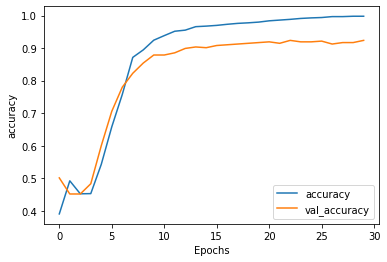

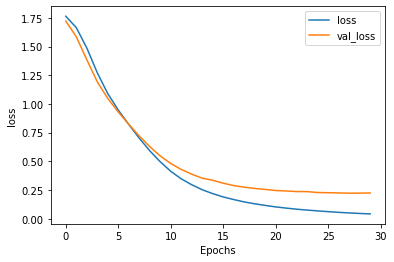

In [42]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")